In [1]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

import ssm
from ssm.util import random_rotation, find_permutation

In [2]:
# Set the parameters of the SLDS
T = 1000    # number of time bins
K = 5       # number of discrete states
D = 2       # number of latent dimensions
N = 100     # number of observed dimensions

In [3]:
# Make an SLDS with the true parameters
true_slds = ssm.SLDS(N, K, D, emissions="poisson_orthog", emission_kwargs=dict(link="softplus"))

# Set rotational dynamics
for k in range(K):
    true_slds.dynamics.As[k] = .95 * random_rotation(D, theta=(k+1) * np.pi/20)
    true_slds.dynamics.bs[k] = 3 * npr.randn(D)
    
# Set an offset to make the counts larger 
# true_slds.emissions.ds += 10

# Sample data
z, x, y = true_slds.sample(T)

# Mask off some data
mask = npr.rand(T, N) < 0.95
y_masked = y * mask

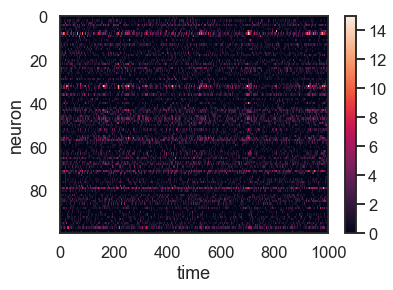

In [4]:
plt.imshow(y.T, aspect="auto", interpolation="none")
plt.xlabel("time")
plt.ylabel("neuron")
plt.colorbar()

In [5]:
print("Fitting SLDS with SVI")
slds = ssm.SLDS(N, K, D, emissions="poisson_orthog", emission_kwargs=dict(link="softplus"))
slds.initialize(y_masked, masks=mask)

q_svi_elbos, q_svi = slds.fit(y_masked, masks=mask, method="bbvi", 
                              variational_posterior="tridiag",
                              initial_variance=1,
                              num_iters=5000, print_intvl=100, initialize=False)
q_svi_x = q_svi.mean[0]

# Find the permutation that matches the true and inferred states
slds.permute(find_permutation(z, slds.most_likely_states(q_svi_x, y)))
q_svi_z = slds.most_likely_states(q_svi_x, y)

# Smooth the observations
q_svi_y = slds.smooth(q_svi_x, y)

Fitting SLDS with SVI
Initializing with an ARHMM using 25 steps of EM.


In [6]:
print("Fitting SLDS with Laplace-EM")
slds = ssm.SLDS(N, K, D, emissions="poisson_orthog", emission_kwargs=dict(link="softplus"))
slds.initialize(y_masked, masks=mask)

q_lem_elbos, q_lem = slds.fit(y_masked, masks=mask, method="laplace_em",
                              variational_posterior="structured_meanfield",
                              num_iters=150, initialize=False, alpha=0)
q_lem_x = q_lem.mean_continuous_states[0]

# Find the permutation that matches the true and inferred states
slds.permute(find_permutation(z, slds.most_likely_states(q_lem_x, y)))
q_lem_z = slds.most_likely_states(q_lem_x, y)

# Smooth the data under the variational posterior
q_lem_y = slds.smooth(q_lem_x, y)

Fitting SLDS with Laplace-EM
Initializing with an ARHMM using 25 steps of EM.


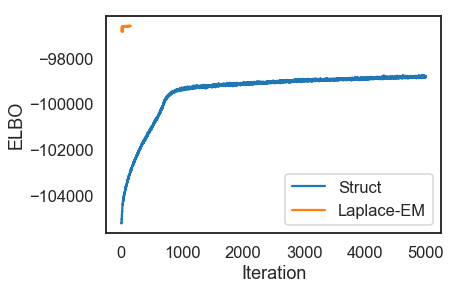

In [7]:
plt.plot(q_svi_elbos, label="Struct")
plt.plot(q_lem_elbos[1:], label="Laplace-EM")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.legend()

(0, 1000)

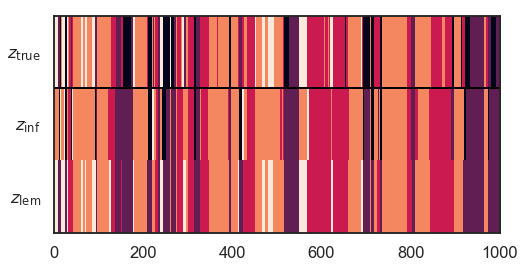

In [8]:
# Plot the true and inferred states
xlim = (0, 1000)

plt.figure(figsize=(8,4))
plt.imshow(np.column_stack((z, q_svi_z, q_lem_z)).T, aspect="auto")
plt.plot(xlim, [0.5, 0.5], '-k', lw=2)
plt.yticks([0, 1, 2], ["$z_{\\mathrm{true}}$", "$z_{\\mathrm{inf}}$", "$z_{\\mathrm{lem}}$"])
plt.xlim(xlim)

(0, 1000)

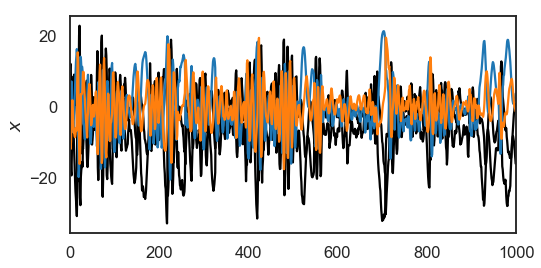

In [9]:
plt.figure(figsize=(8,4))
plt.plot(x, '-k')
plt.plot(q_svi_x, '-')
plt.ylabel("$x$")
plt.xlim(xlim)

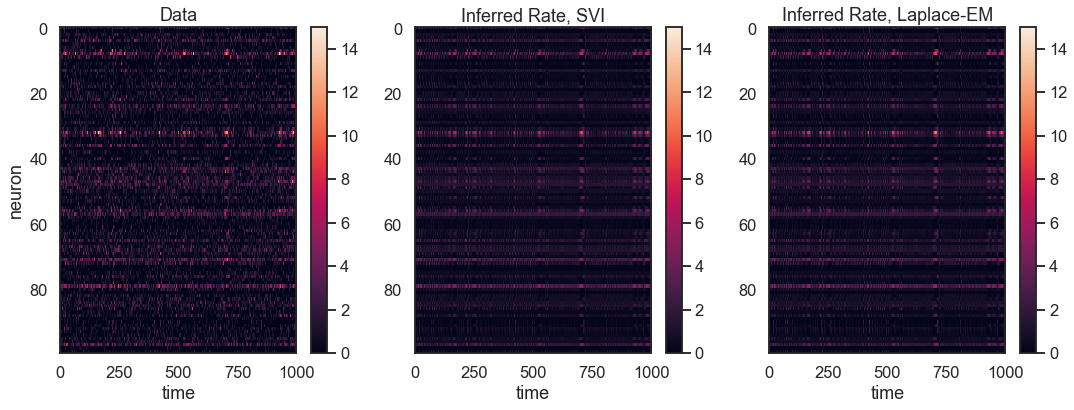

In [10]:
# Plot the smoothed observations
lim = max(y.max(), q_svi_y.max(), q_lem_y.max())
plt.figure(figsize=(18,6))
plt.subplot(131)
plt.imshow(y.T, aspect="auto", vmin=0, vmax=lim)
plt.ylabel("neuron")
plt.xlabel("time")
plt.title("Data")
plt.colorbar()

plt.subplot(132)
plt.imshow(q_svi_y.T, aspect="auto", vmin=0, vmax=lim)
plt.xlabel("time")
plt.title("Inferred Rate, SVI")
plt.colorbar()

plt.subplot(133)
plt.imshow(q_lem_y.T, aspect="auto", vmin=0, vmax=lim)
plt.xlabel("time")
plt.title("Inferred Rate, Laplace-EM")
plt.colorbar()